# EPIC 220208795 -- Testrun

In this notebook we take the eclipse obtained from the k2_lightcurve - EPIC 2202 notebook and create a test model. We do this using the <strong>pyPplusS</strong> package designed by Rein & Odir 2019. We specifically look at an Opaque Disk model ($\tau = 1$).

In [1]:
import emcee
import logging
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from Code import mcmc, eclipse

%matplotlib inline

## Load the Data

In [2]:
time, flux, error = np.loadtxt('data 2202/eclipse_lightcurve2202.txt', skiprows=1).T

No handles with labels found to put in legend.


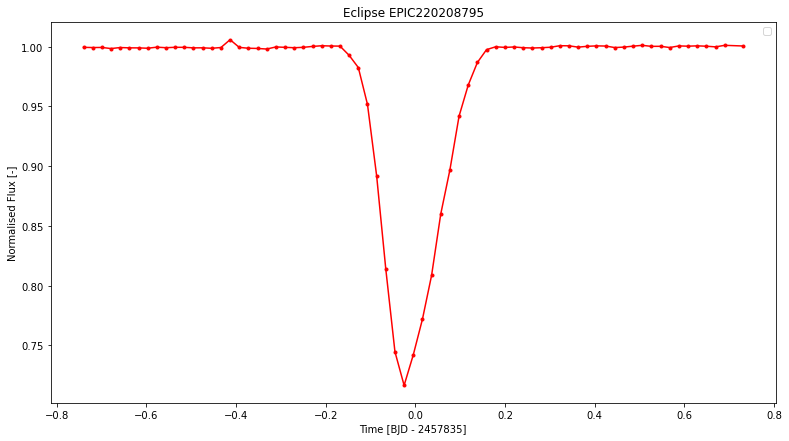

In [3]:
plt.figure(figsize=(13, 7))
plt.title('Eclipse EPIC220208795')
plt.xlabel('Time [BJD - 2457835]')
plt.ylabel('Normalised Flux [-]')
plt.errorbar(time, flux, yerr=error, fmt='.', color='r', ls='-')
plt.legend()
plt.show()

## Model Set-up

This takes the <strong>disk_model()</strong> function from <strong>eclipse_functions</strong>, and creates the opaque disk model ($r_{\mathrm{edge}} = 0, \ \tau_{\mathrm{edge}} = 0, \ \tau_{\mathrm{disk}} = 0$)

In [4]:
# model functions
pack_od = lambda rd, b, inc, tilt, vel, dx: (rd, 0., b, inc, tilt, vel, dx, 1., 0.)
opaque_disk      = lambda P, time: eclipse.disk_model(pack_od(*P), time)
opaque_prior      = lambda P: eclipse.disk_prior(pack_od(*P))

In [5]:
# Bounds of the parameters (t = tilt, T = tau, rest as above)
rl, ru = (0., 10.)
bl, bu = (-10.,10.)
il, iu = (0., np.pi/2.)
tl, tu = (0., np.pi/2.)
vl, vu = (4.3, 20.) # 220208795
xl, xu = (-10.,10.)
Tl, Tu = (0.,1.)

## Opaque Disk

In [6]:
# setting the the parameter names, units and bounds
lbls_od = ['disk radius', 'impact parameter', 'inclination', 'tilt', 'velocity', 
           'time shift']
units_od = ['R*', 'R*', 'deg', 'deg', 'R*/day', 'day']
bounds_od = [(rl, ru/2.), (bl/2., bu/2.), (iu/2., iu), (tl, tu), (vl, vu/2.), (-0.5, 0.5)]

# set-up intial guess for the opaque disk
pargs_od = (6, 1000, bounds_od)
p0_od = eclipse.useful_p0(mcmc.bounded_p0, pargs_od, opaque_disk, time, False, 4)

  0%|▎                                                                                | 4/1000 [00:00<00:27, 36.47it/s]

round 1 from 0 to 865 (max = 1000)


  0%|▏                                                                                | 2/1000 [00:00<00:54, 18.19it/s]

round 2 from 865 to 1000 (max = 1000)


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [01:07<00:08, 13.17it/s]


KeyboardInterrupt: 

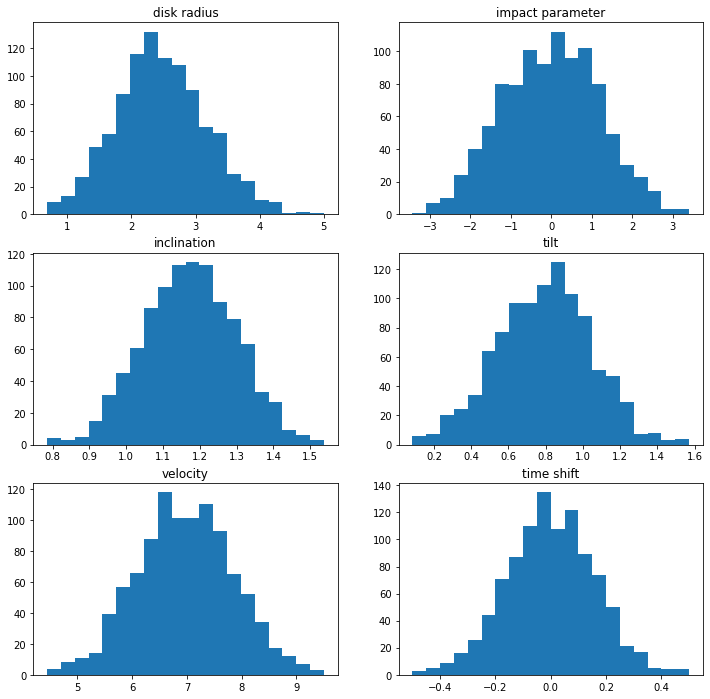

In [47]:
# plot intial guess histogram
mcmc.plot_hist(p0_od, lbls=lbls_od)

In [8]:
# mcmc parameters for opaque disk
be_od = 'models 2202/opaque_disk_2202.h5'
args_od = (time, flux, error, opaque_disk, opaque_prior)
BE_od = emcee.backends.HDFBackend(be_od)

# run mcmc for opaque disk
#p_od, sampler_od = mcmc.run_mcmc(*args_od, p0_od, 1000, reset=False, savename=be_od)

# load mcmc for opaque disk
sampler_od = emcee.EnsembleSampler(1000, 6, mcmc.lnprob, args=args_od, backend=BE_od)

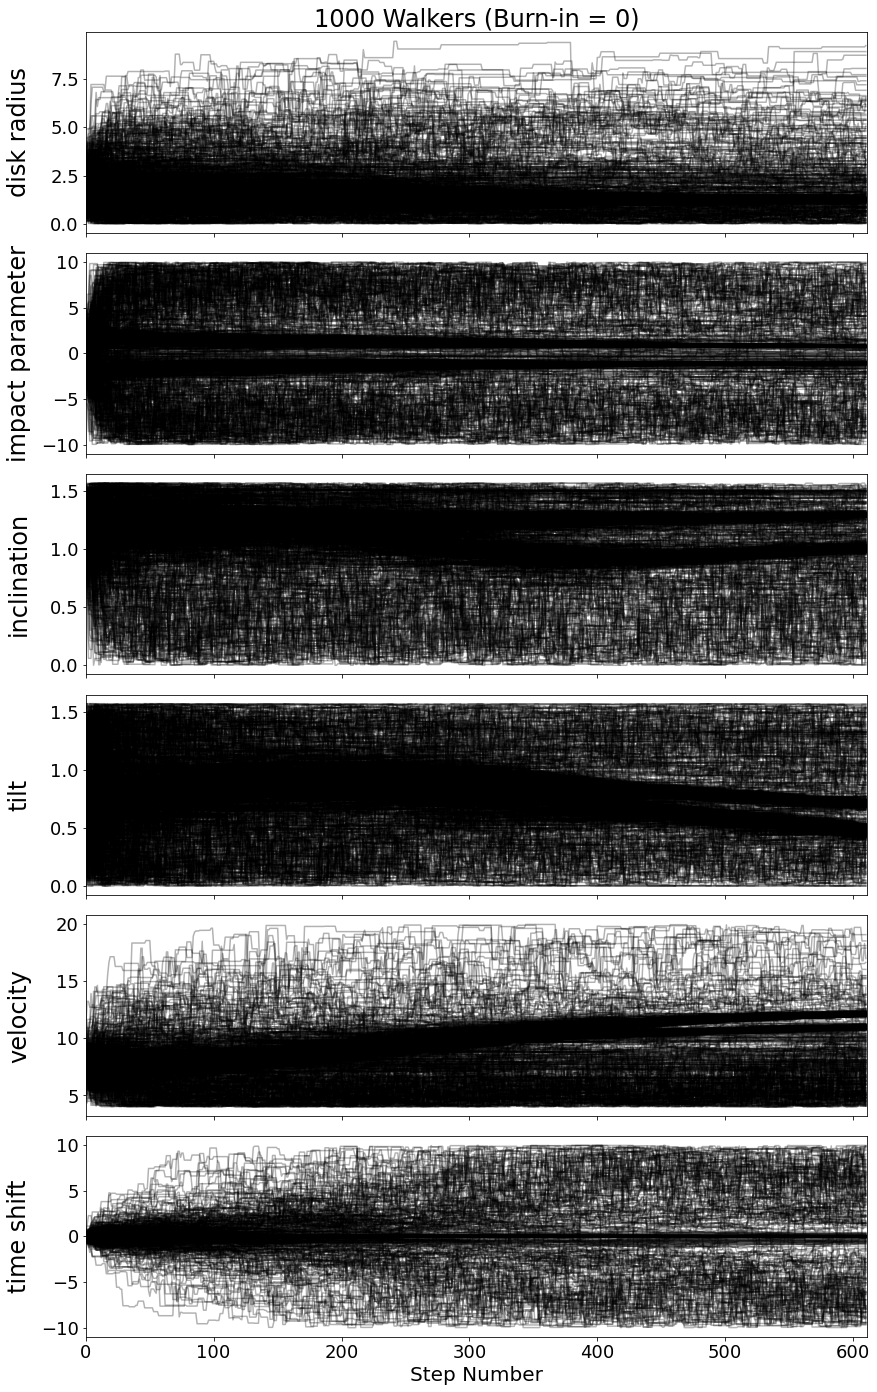

In [9]:
# plot the walkers for the opaque disk
mcmc.plot_walkers(sampler_od, lbls=lbls_od)

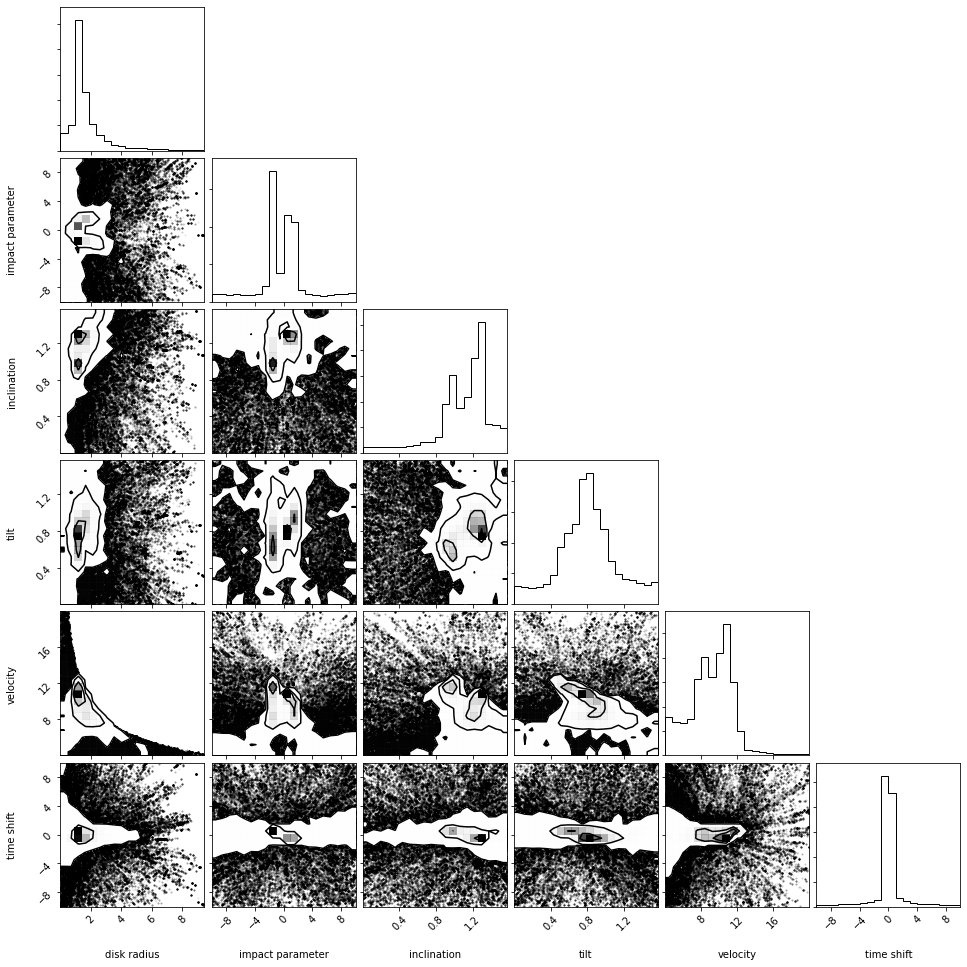

In [10]:
# plot the triangle for the opaque disk
mcmc.plot_triangle(sampler_od, lbls=lbls_od)

From these plots we see that there is still some spread, and there are two peaks clearly seen in impact parameter and inclination. Based on this we separate the solutions into high and low inclination.

### Separating Solutions (Inclination) for the Testrun Disk

Here we extract the solutions with inclination between 0.9-1.1 and 1.1-1.3.

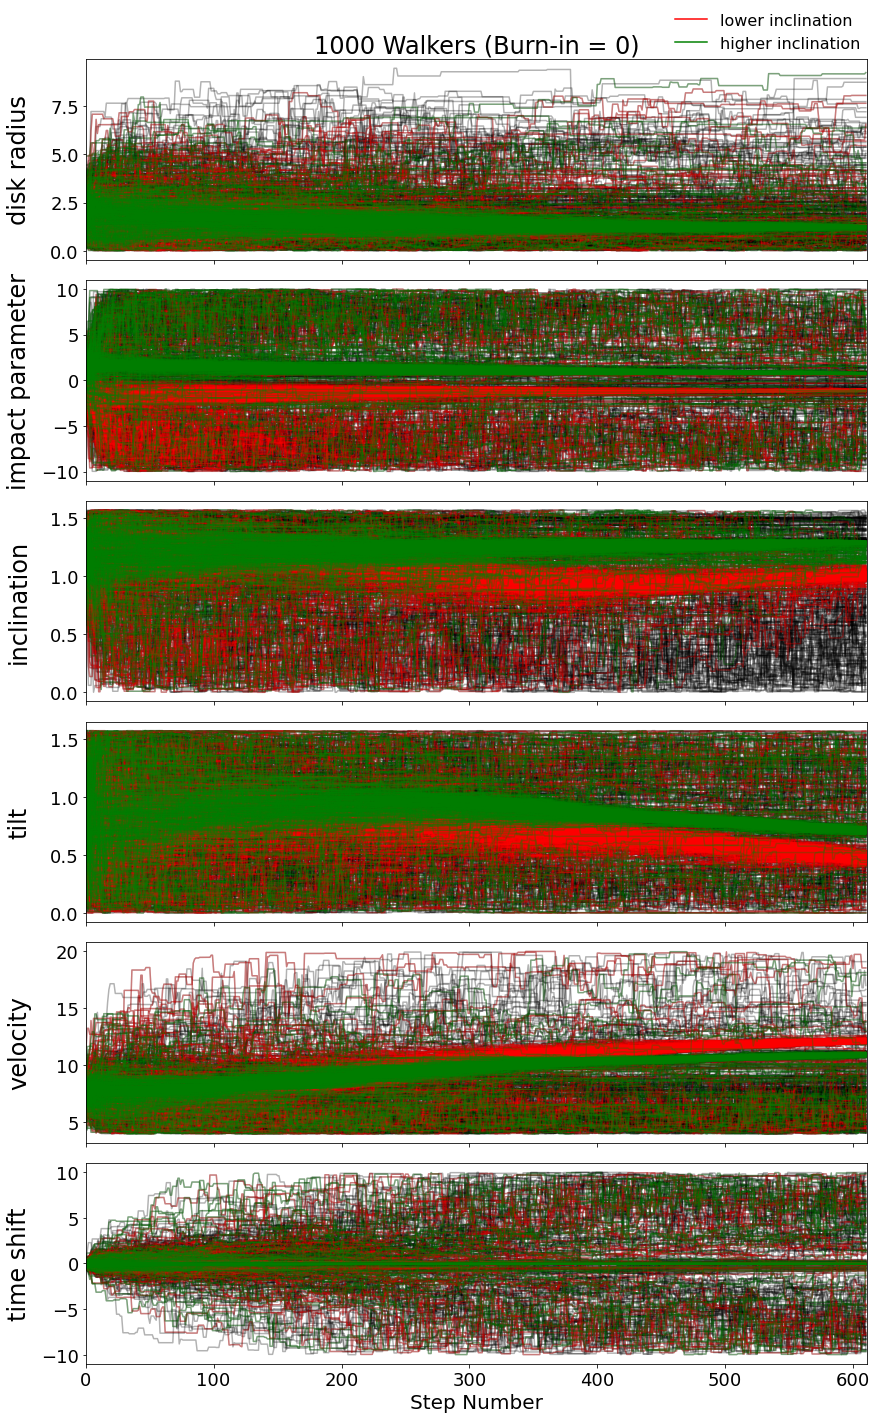

In [11]:
# extracting the low and high inclination solutions for the testrun disk
incl_names_od = ['lower inclination', 'higher inclination']
lincl_od, hincl_od = mcmc.extract_solutions(sampler_od, [2, 2], [(0.9, 1.1), (1.1, 1.3)], 0, lbls_od, incl_names_od)


#### High Inclination Solutions for the Testrun Disk

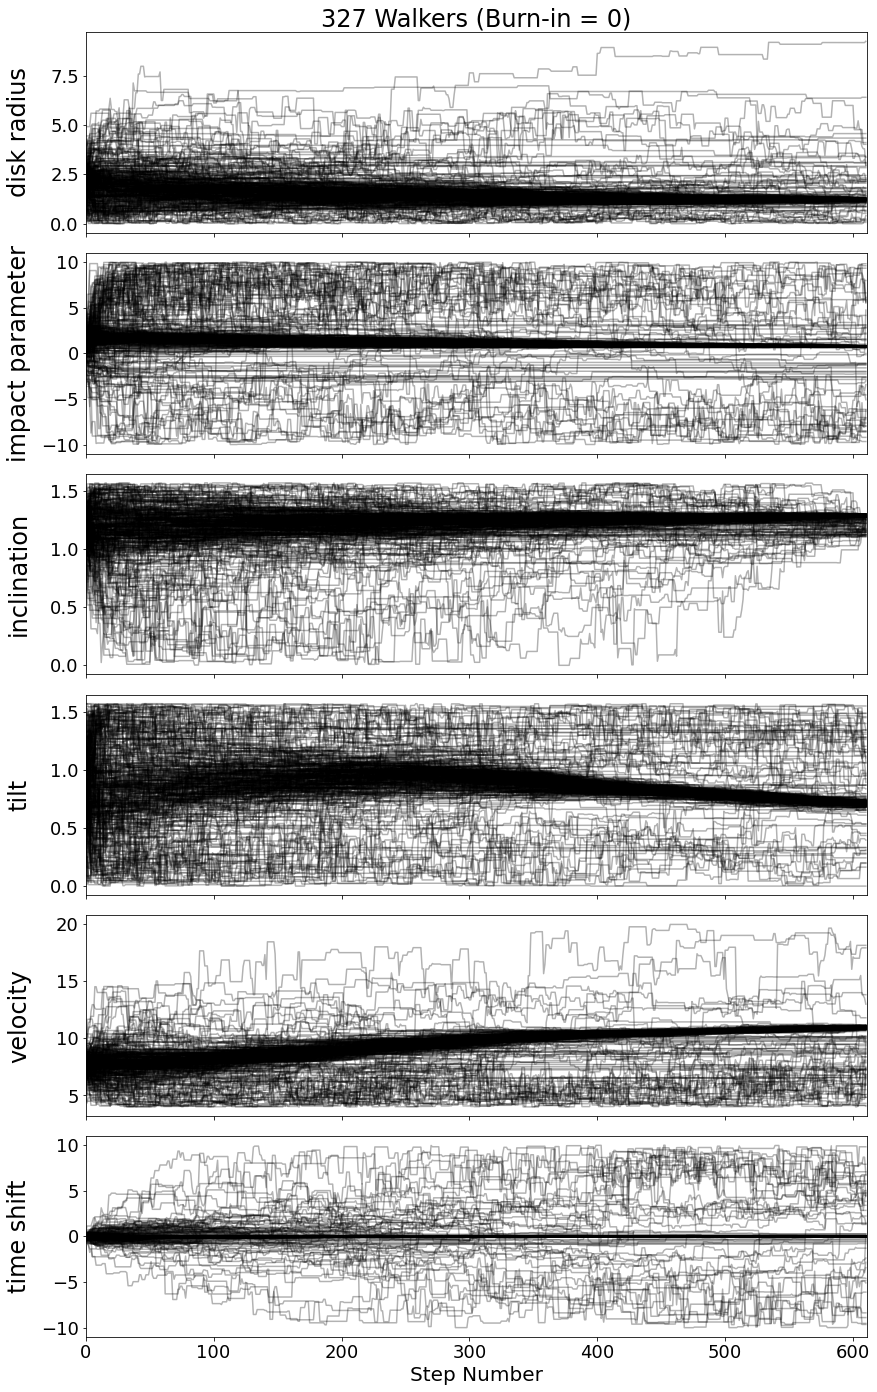

In [12]:
# plot the high inclination walkers for the testrun disk
mcmc.plot_walkers(hincl_od, lbls=lbls_od)

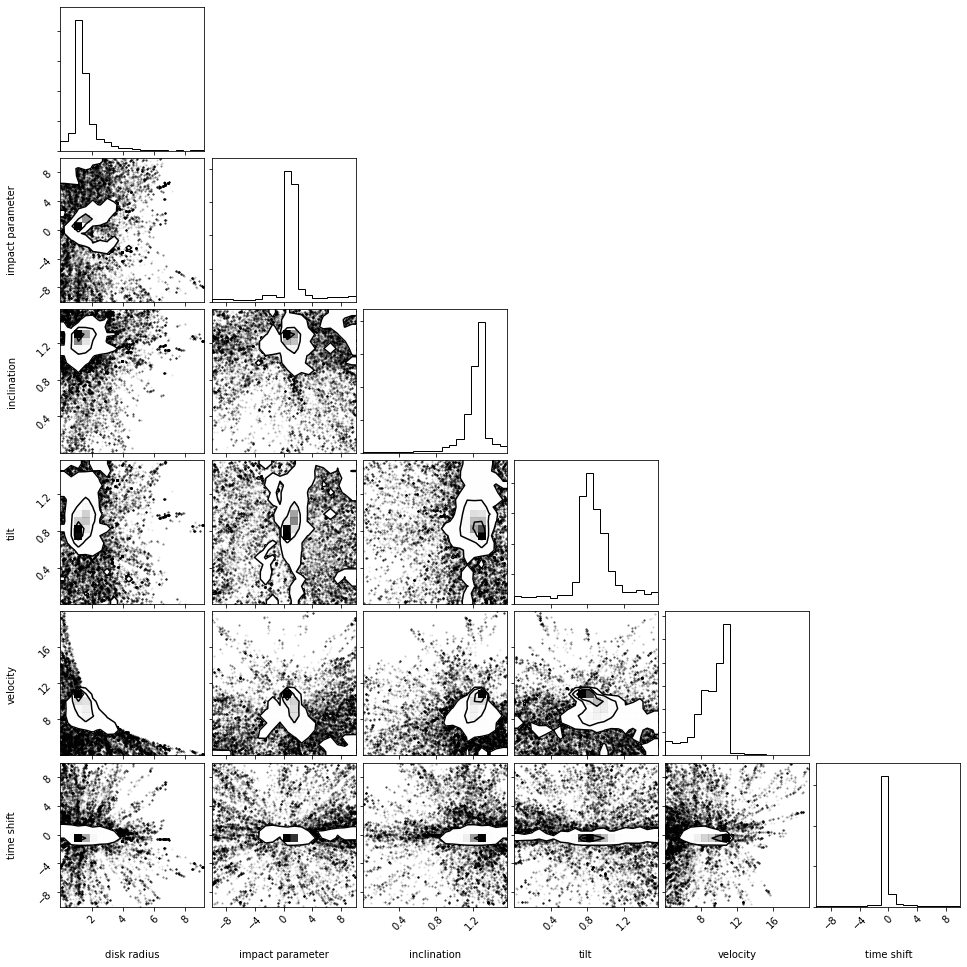

In [13]:
# plot the high inclination triangle for the testrun disk
mcmc.plot_triangle(hincl_od, lbls=lbls_od)

Clearly there is just one peak where everything moves to so we can cut away the burn-in time and carry out the statistics to get a best fit solution for the high-velocity set of solutions. To check we plot the walkers and the triangle plot.

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 12.10it/s]


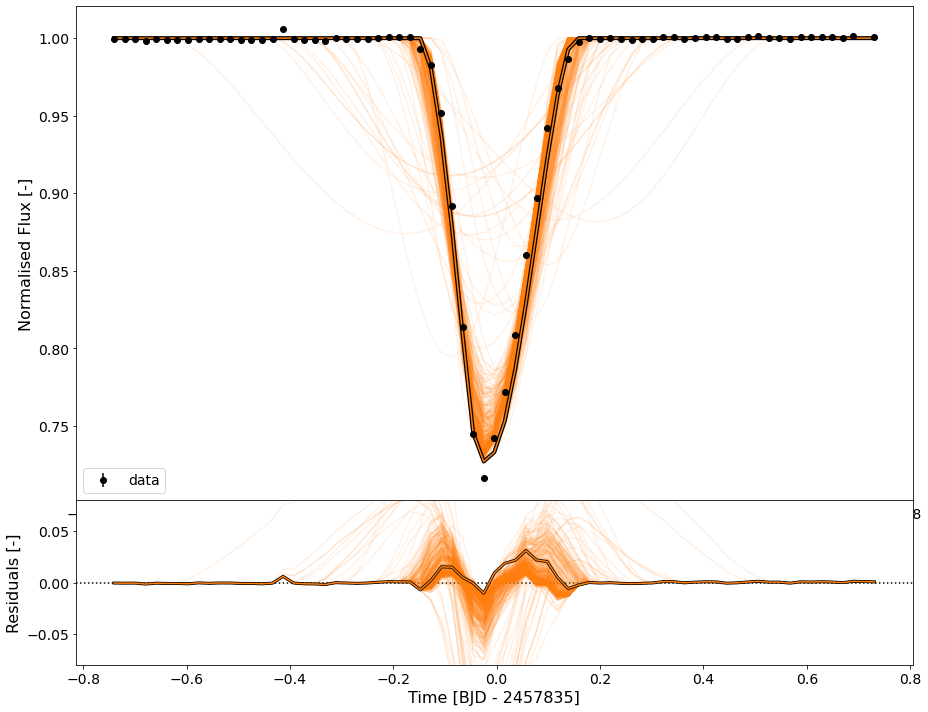

In [14]:
# deciding the burn-in for the high inclination solutions for the opaque disk
cut_hincl_od = 100

# carrying out statistics for the high inclination solutions for the opaque disk
stats_hincl_od, pb_hincl_od = mcmc.stats(hincl_od, cut=cut_hincl_od)

# making plot of the samples for the high inclination solutions for the opaque disk
_ = mcmc.plot_samples(time, flux, error, [opaque_disk], [hincl_od], [''], cut_hincl_od, 500, 
                      best_fit=True, dt=3002, residual_lims=(-0.08, 0.08))

In [15]:
# printing the high inclination best-fit solution for the opaque disk
mcmc.print_parameters(pb_hincl_od, lbls_od, units_od)

disk radius        =     +1.316756     [R*]
impact parameter   =     +0.949811     [R*]
inclination        =     +72.14610     [deg]
tilt               =     +48.58506     [deg]
velocity           =     +9.950450     [R*/day]
time shift         =     -0.042518     [day]


#### Low Inclination Solutions for the Opaque Disk

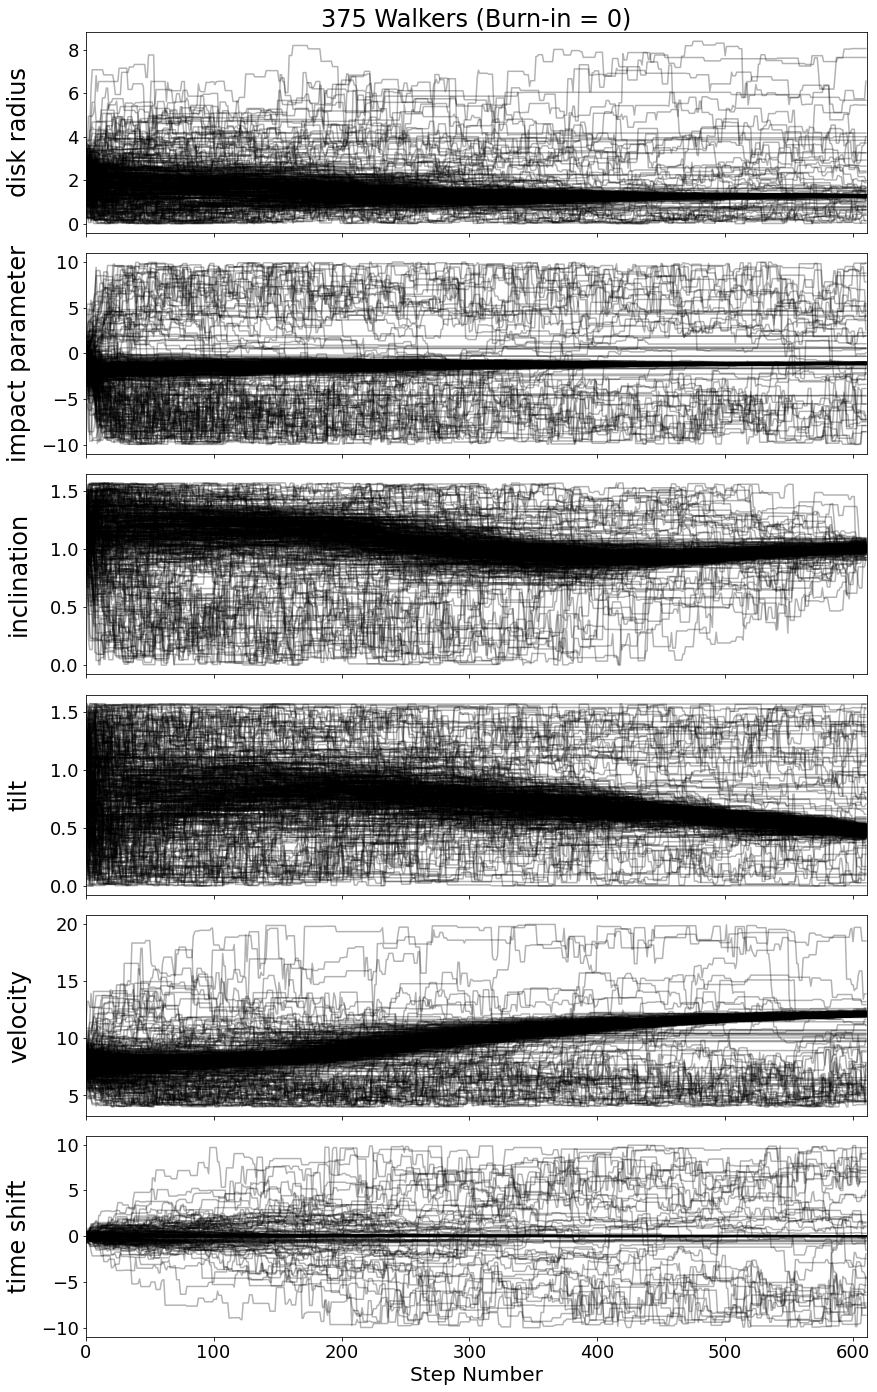

In [17]:
# plot the low inclination walkers for the opaque disk
mcmc.plot_walkers(lincl_od, lbls=lbls_od)

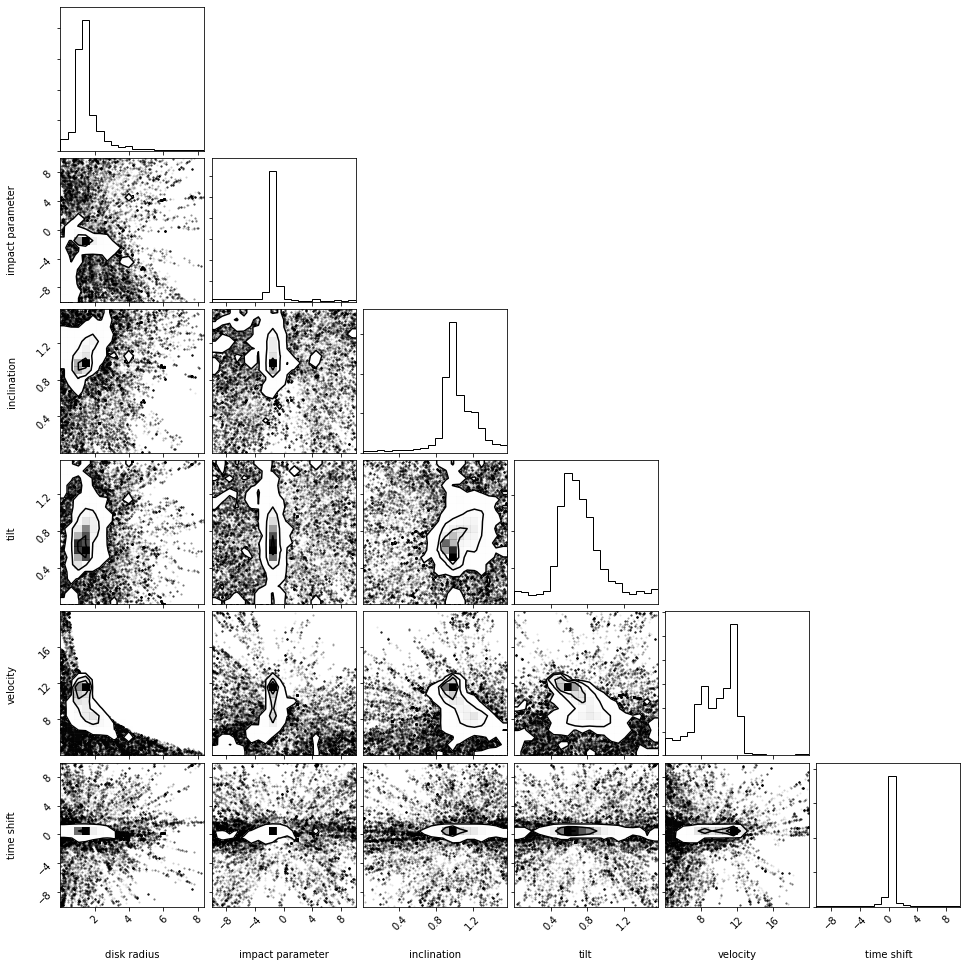

In [18]:
# plot the low inclination triangle for the opaque disk
mcmc.plot_triangle(lincl_od, lbls=lbls_od)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.69it/s]


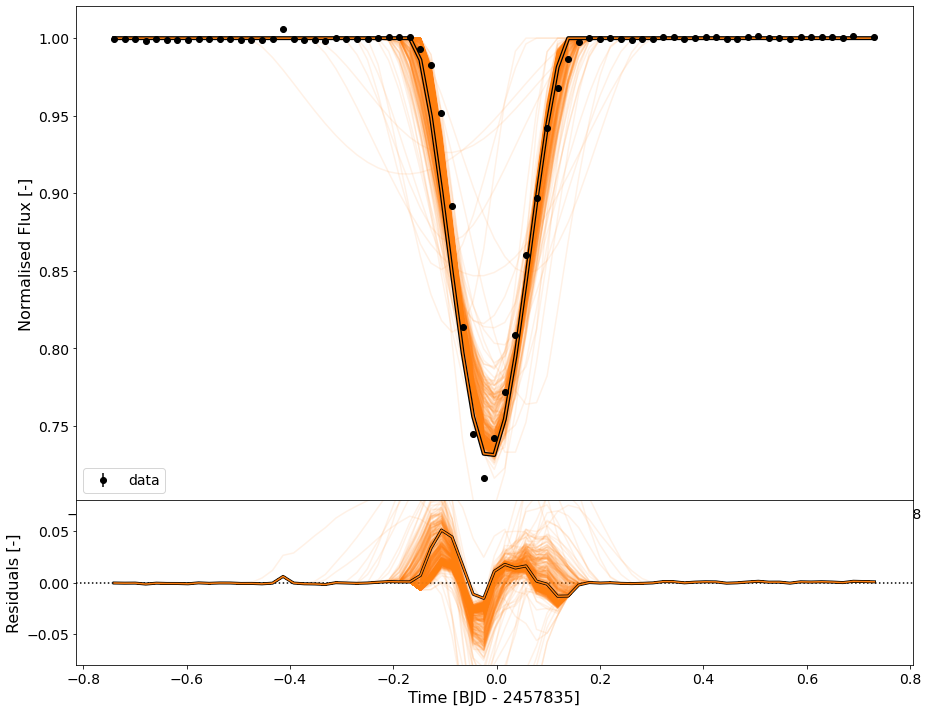

In [19]:
# deciding the burn-in for the low inclinationsolutions for the opaque disk
cut_lincl_od = 100

# carrying out statistics for the low inclination solutions for the opaque disk
stats_lincl_od, pb_lincl_od = mcmc.stats(lincl_od, cut=cut_lincl_od)

# making plot of the samples for the low inclination solutions for the opaque disk
_ = mcmc.plot_samples(time, flux, error, [opaque_disk], [lincl_od], [''], cut_lincl_od, 500, 
                      best_fit=True, dt=3002, residual_lims=(-0.08, 0.08))

In [20]:
# printing the low inclination best-fit solution for the testrun disk
mcmc.print_parameters(pb_lincl_od, lbls_od, units_od)

disk radius        =     +1.287264     [R*]
impact parameter   =     -1.175721     [R*]
inclination        =     +56.45482     [deg]
tilt               =     +38.63207     [deg]
velocity           =     +10.56517     [R*/day]
time shift         =     +0.019783     [day]


In [23]:
# saving the best fit model, which is the high inclination one
np.save('models 2202/disk_high_inclination_2202.npy', pb_hincl_od)